In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from Windowing import *

In [2]:
# take out the duplicate higgs dataset we have id: 23512 and 42769
# We take out 23512 as it has less anchor points (eventhough it has 2 more learners but those are just 2 more variations of SVC)
aggCurves = aggCurves[aggCurves['openmlid'] != 23512]
anchors = aggCurves[aggCurves['openmlid'] == 42769]['size_train'].unique()

In [3]:
# For regularization
win = Windowing(aggCurves)
win.set_points(list(anchors))
learningCurves = win.data
targets = win.target

,Count
size_train,
16,244
23,245
32,245
40,1
45,243
...,...
1048576,2
1482910,1
1486391,1


In [4]:
# Higgs dataset
HiggsLCs = learningCurves[-3]
HiggsTargets = targets[-3]

# Remove it from the numpy arrays
MetaLearningCurves = np.delete(learningCurves, -3, 0)
MetaTargets = np.delete(targets, -3, 0)

# Last and MMF

In [5]:
LastPred = np.diagonal(HiggsLCs, axis1=-2, axis2=-1).copy()
LastError = np.abs(LastPred[..., None] - HiggsTargets)
LastPred = np.copy(HiggsLCs)

In [6]:
# Tensorise variables
target = torch.tensor(HiggsTargets, dtype=torch.float32)
data = torch.tensor(HiggsLCs, dtype=torch.float32)
train_anchors = torch.tensor(win.train_anchors, dtype=torch.float32)[:, None]
weights = (2 ** torch.arange(win.s))[:, None]
params = torch.tensor([0.5, 1, 1, -1], dtype=torch.float32)
shp = np.hstack((np.array(data.shape[:1]), np.array(data.shape[2])))

params = params.repeat(*shp, 1)[:, None]  # since len(dim[1]) = len(dim[2])

params.requires_grad_()
gr = torch.ones(*shp)  # For .backward(), usually only takes a scalar but with this it doesn't need  to

# Func to optimise
def mmf_func(beta, x):
    return (beta[..., 0] * beta[..., 1] + beta[..., 2] * x ** beta[..., 3]) / (beta[..., 1] + x ** beta[..., 3])

lr = 0.01
steps = 4000

optimizer = torch.optim.Adam([params], lr=lr)  # SGD did weird things, Adam works well!
y = data
nan = torch.isnan(y)
y = torch.where(nan, torch.tensor(0.0), y)

for i in range(steps):
    optimizer.zero_grad()
    # Sum over last dim, watch out with nan's maybe?
    out = mmf_func(params, train_anchors)
    out = torch.where(nan, torch.tensor(0.0), out)
    loss = (((out - y) ** 2) * weights).sum(1)
    # Each curve has separate .backward() with this
    loss.backward(gradient=gr)
    optimizer.step()

params.requires_grad = False  # To not waste computation
target_points = torch.tensor(win.target_anchors, dtype=torch.float32)[:,None]
prediction = mmf_func(params, target_points)
prediction = torch.einsum('ikl->ilk', prediction)
prediction[nan] = np.nan

MMFPred = prediction.numpy()
MMFError = (prediction - target).abs().numpy()
MMFParams = params[:,0].numpy()

In [7]:
def plot_mmf(learner, window):

    # predicted lc
    fig, ax = plt.subplots()
    x = np.linspace(win.train_anchors[0], win.target_anchors[-1], 10000)
    a, b, c, d = MMFParams[learner, window]
    fun = lambda x: (a * b + c * x ** d) / (b + x ** d)
    ax.plot(x, fun(x), label='MMF prediction')

    #given lc
    ax.scatter(win.train_anchors, HiggsLCs[learner, :,window], label='Learning curve (given)')

    #target lc
    ax.scatter(win.target_anchors, HiggsTargets[learner, window], label='Learning curve (target)')



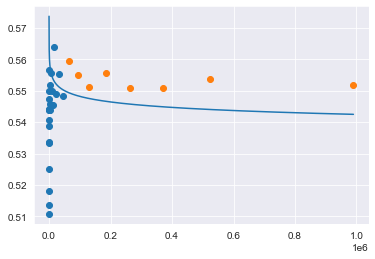

In [8]:
# learner 8,9, 12 are interesting as MMF cannot approximate them well when lc's descend after ascending
plot_mmf(8,23)

# MDS

In [9]:
MetaSegment = np.delete(win.segment, -3, 0)

count = []
# Check anchor point similarity in the meta segment
for i in range(MetaSegment.shape[0]):
    temp = MetaSegment[i]
    temp[np.isnan(temp)] = 0
    emptyLearners = np.where(temp.sum(axis = -1)==0)[0]
    temp = np.delete(temp, emptyLearners, 0)

    # Do the learners have the same anchor points?
    nans = (temp == 0)
    similar = [np.all(nans[0] == nans[i]) for i in range(nans.shape[0])]
    if False in similar:
        print(i)

    # some datasets don't have any of the anchor points, skip them
    if not nans.any():
        continue

    # Do they skip anchors?
    nanchors = np.sum(nans[0] == 0) #as all learners have same anchor points
    last_id = np.where(nans[0] != 0)[0][0]
    if nanchors != last_id:
        print(i)

    print(f'DS {i}: {nanchors}/32')
    count.append(nanchors)






DS 0: 15/32
DS 1: 19/32
DS 2: 9/32
DS 3: 13/32
DS 4: 7/32
DS 5: 13/32
DS 6: 13/32
DS 7: 13/32
DS 8: 13/32
DS 9: 13/32
DS 10: 13/32
DS 11: 17/32
DS 12: 19/32
DS 13: 17/32
DS 14: 17/32
DS 15: 11/32
DS 16: 19/32
DS 17: 13/32
DS 18: 15/32
DS 19: 15/32
DS 20: 15/32
DS 21: 11/32
DS 22: 5/32
DS 23: 15/32
DS 24: 15/32
DS 25: 5/32
DS 26: 23/32
DS 27: 25/32
DS 28: 13/32
DS 29: 17/32
DS 30: 21/32
DS 31: 13/32
DS 32: 11/32
DS 33: 19/32
DS 34: 25/32
DS 35: 31/32
DS 36: 9/32
DS 37: 17/32
DS 38: 7/32
DS 39: 3/32
DS 40: 29/32
DS 41: 31/32
DS 42: 25/32
DS 43: 3/32
DS 44: 13/32
DS 45: 17/32
DS 46: 13/32
DS 47: 11/32
DS 48: 15/32
DS 49: 13/32
DS 50: 15/32
DS 51: 13/32
DS 52: 19/32
DS 53: 11/32
DS 54: 7/32
DS 55: 23/32
DS 56: 11/32
DS 57: 11/32
DS 58: 11/32
DS 59: 15/32
DS 60: 19/32
DS 61: 11/32
DS 62: 23/32
DS 63: 15/32
DS 64: 19/32
DS 65: 17/32
DS 66: 15/32
DS 67: 11/32
DS 68: 11/32
DS 69: 11/32
DS 70: 11/32
DS 71: 17/32
DS 72: 17/32
DS 73: 13/32
DS 74: 11/32
DS 75: 11/32
DS 76: 17/32
DS 77: 11/32
DS 78

(array([241., 241., 241., 241., 239., 239., 233., 233., 222., 222., 217.,
        217., 176., 176., 134., 134., 101., 101.,  67.,  67.,  48.,  48.,
         39.,  39.,  22.,  22.,  13.,  13.,   9.,   9.,   7.,   7.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <BarContainer object of 33 artists>)

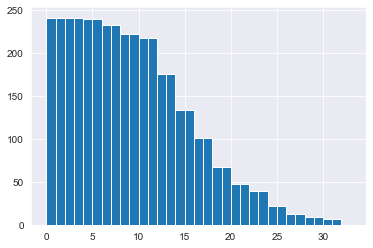

In [10]:
# print the frequency of each, do cummulutives but other way around
plt.hist(count, bins=np.arange(0,34), cumulative=-1)

In [11]:
dataHiggs = np.copy(HiggsLCs)
MetaData = np.copy(MetaLearningCurves)
MetaData[..., win.triu[1], win.triu[0]] = 0
dataHiggs[..., win.triu[1], win.triu[0]] = 0

weights = (2 ** np.arange(win.s))[:, None]
scalar = np.sum(weights * MetaData * dataHiggs[None], axis=2) / np.sum(weights * (MetaData ** 2), axis=2)
adapted_target = scalar[..., None] * MetaTargets
distance = np.sum((MetaData - dataHiggs[None]) ** 2, axis=2)

# extra dim for moving target
distance = np.repeat(distance[..., None], len(win.target_anchors), axis=-1)

# Remove curves that can't predict at target
ind = np.isnan(MetaTargets[...,0,:]).nonzero()
distance[ind[0], ind[1], ..., ind[2]] = np.nan

k = 4

# Take k closest
distance_binary = distance[:, None] + distance[:, :, None]

# We need an extra dimension for the rival learner
adapted_target_binary = np.repeat(adapted_target[:, :, None], adapted_target.shape[1], axis=2)
part_binary = np.argpartition(distance_binary, k, axis=0)[:k]
part_regression = np.argpartition(distance, k, axis=0)[:k]

k_closest_curves_binary = np.take_along_axis(adapted_target_binary, part_binary, axis=0)
k_closest_curves_regression = np.take_along_axis(adapted_target, part_regression, axis=0)

# For binary we need the prediction of both learners then we check which one is larger
# For rival learner we can just swap the learner axis
k_closest_curves_binary_rival = np.swapaxes(k_closest_curves_binary, 1, 2)

prediction_l1 = np.mean(k_closest_curves_binary, axis=0)
prediction_l2 = np.mean(k_closest_curves_binary_rival, axis=0)

# regression
prediction_regression = np.mean(k_closest_curves_regression, axis=0)

# Check when l1 wins over l2
prediction_binary = (prediction_l1 > prediction_l2).astype(float)

# Check for ties
prediction_binary[prediction_l1 == prediction_l2] = 0.5

# Return nans as they get removed
prediction_binary[np.isnan(prediction_l1)] = np.nan
prediction_binary[np.isnan(prediction_l2)] = np.nan

# Don't compete against same learner
np.einsum('jj...->j...', prediction_binary)[...] = np.nan

MDSPredictionBinary = prediction_binary
MDSPredictionRegression = prediction_regression
MDSError = np.abs((prediction_regression - HiggsTargets))

In [12]:
def plot_mds(learner, window, target):

    # k nearest lc's
    fig, ax = plt.subplots()

    knn = part_regression[:, learner, window, target]
    for k in knn:
        c = scalar[k, learner, window]
        ax.scatter(win.train_anchors, c * MetaLearningCurves[k, learner, :,-1], s=5)


    #given lc
    ax.scatter(win.train_anchors, HiggsLCs[learner, :,window], label='Learning curve (given)')

    #target lc
    ax.scatter(win.target_anchors, HiggsTargets[learner, window], label='Learning curve (target)')

    # prediction point
    ax.scatter(win.target_anchors[target], prediction_regression[learner, window, target], label='Prediction point', c='r', marker='x')

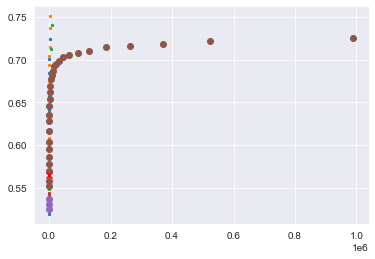

In [13]:
# there are very little meta sets at higher anchors (nly like 7) so there it is pretty bad
plot_mds(4, 2, 6)

In [14]:
# We make function so that it is easier to do for multiple different windows/targets
# This function will perform the binary comparison for the given data
def Binary(data):
    # Which learner would win in the binary problem
    predictions = (data[:,None] > data[None]).astype(float)

    # keep nans
    nans = np.isnan(data[:,None]) + np.isnan(data[None])
    predictions[nans] = np.nan

    # Make ties 0.5
    predictions[data[:,None] == data[None]] = 0.5

    # Don't compete against same learner
    np.einsum('jj...->j...', predictions)[...] = np.nan

    return predictions

In [15]:
# We get the binary predictions
MMFPredictionBinary = Binary(MMFPred)
LastPredictionBinary = Binary(LastPred)
actualPredictionBinary = Binary(HiggsTargets)

In [16]:
# Tie means no learning curve crossing thus we predict the largest last anchor
# this is the same as using last
MDSPredictionBinary[MDSPredictionBinary == 0.5] = LastPredictionBinary[MDSPredictionBinary == 0.5]
MMFPredictionBinary[MMFPredictionBinary == 0.5] = LastPredictionBinary[MMFPredictionBinary == 0.5]
actualPredictionBinary[actualPredictionBinary == 0.5] = LastPredictionBinary[actualPredictionBinary == 0.5]
# Because we round down with int(0.5) later, right wins by default

In [17]:
win.target.shape

(247, 20, 31, 31)

In [18]:
# All true values, so we flip it around, now left is right and right is left. This is because we have set 1 as left and 0 as right
# in the binary setting, thus we flip it around here as numpy sees 1 as right and 0 as left
true = np.stack([HiggsTargets[None] +0*HiggsTargets[:,None], HiggsTargets[None]*0 +HiggsTargets[:,None]])

def regret_calc(dat):
    # Indexes for the predictions
    temp = np.copy(dat)
    nans = np.isnan(temp)
    temp[nans] = 0
    temp = temp.astype(int)

    # Indexes for the true values
    temp2 = np.copy(actualPredictionBinary)
    nans2 = np.isnan(temp2)
    temp2[nans2] = 0
    temp2 = temp2.astype(int)

    # regret
    regret = np.squeeze(np.take_along_axis(true, temp2[None], axis=0) - np.take_along_axis(true, temp[None], axis=0))
    regret[nans] = np.nan
    regret[nans2] = np.nan

    return regret

In [19]:
# Regret for each method
MDSregret = regret_calc(MDSPredictionBinary)
MMFregret = regret_calc(MMFPredictionBinary)
Lastregret = regret_calc(LastPredictionBinary)

# Plots

In [20]:
LastError.shape

(20, 31, 31)

In [21]:
MMFError.shape

(20, 31, 31)

In [22]:
MDSError.shape

(20, 31, 31)

In [23]:
LastBinaryError = np.abs(LastPredictionBinary - actualPredictionBinary)
MMFBinaryError = np.abs(MMFPredictionBinary - actualPredictionBinary)
MDSBinaryError = np.abs(MDSPredictionBinary - actualPredictionBinary)

In [24]:
regretAveragesMDSvsMMF = np.nanmean(MDSregret - MMFregret, axis=(0,1))
regretAveragesMDSvsLast = np.nanmean(MDSregret - Lastregret, axis=(0,1))
regretAveragesMMFvsLast = np.nanmean(MMFregret - Lastregret, axis=(0,1))

averagesMDSvsMMF = np.nanmean(MDSBinaryError - MMFBinaryError, axis=(0,1))
averagesMDSvsLast = np.nanmean(MDSBinaryError - LastBinaryError, axis=(0,1))
averagesMMFvsLast = np.nanmean(MMFBinaryError - LastBinaryError, axis=(0,1))

KmeanaveragesMDSvsMMF = np.nanmean(MDSError - MMFError, axis=0)
KmeanaveragesMDSvsLast = np.nanmean(MDSError - LastError, axis=0)
KmeanaveragesMMFvsLast = np.nanmean(MMFError - LastError, axis=0)

C:\Users\lkiel\AppData\Local\Temp\ipykernel_7052\3619199627.py:1: RuntimeWarning: Mean of empty slice
  regretAveragesMDSvsMMF = np.nanmean(MDSregret - MMFregret, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_7052\3619199627.py:2: RuntimeWarning: Mean of empty slice
  regretAveragesMDSvsLast = np.nanmean(MDSregret - Lastregret, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_7052\3619199627.py:3: RuntimeWarning: Mean of empty slice
  regretAveragesMMFvsLast = np.nanmean(MMFregret - Lastregret, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_7052\3619199627.py:5: RuntimeWarning: Mean of empty slice
  averagesMDSvsMMF = np.nanmean(MDSBinaryError - MMFBinaryError, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_7052\3619199627.py:6: RuntimeWarning: Mean of empty slice
  averagesMDSvsLast = np.nanmean(MDSBinaryError - LastBinaryError, axis=(0,1))
C:\Users\lkiel\AppData\Local\Temp\ipykernel_7052\3619199627.py:7: RuntimeWarning: Mean of empty slice
  average

C:\Users\lkiel\AppData\Local\Temp\ipykernel_7052\317352146.py:105: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
C:\Users\lkiel\AppData\Local\Temp\ipykernel_7052\317352146.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


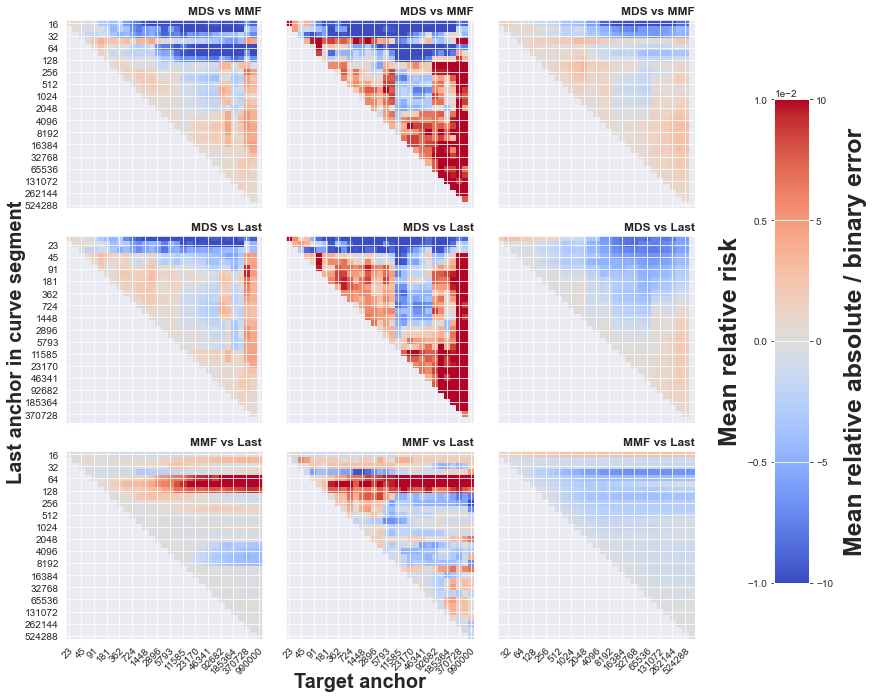

In [25]:
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

# w = 2
# h = 3.5
w, h = (1.5, 2)
fig, ax = plt.subplots(3,3, figsize=(6.4 * w, 4.8 * h))


a = ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')
ax[1][0].imshow(regretAveragesMDSvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')
ax[2][0].imshow(regretAveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.01, vmax = 0.01, aspect='auto')


b = ax[0][1].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[2][1].imshow(averagesMMFvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)
ax[1][1].imshow(averagesMDSvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1)

# set title
ax[0][0].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][0].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][0].set_title('MDS vs Last', weight = 'bold', loc='right')

ax[0][1].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][1].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][1].set_title('MDS vs Last', weight = 'bold', loc='right')

ax[0][2].set_title('MDS vs MMF', weight = 'bold', loc='right')
ax[2][2].set_title('MMF vs Last', weight = 'bold', loc='right')
ax[1][2].set_title('MDS vs Last', weight = 'bold', loc='right')

c = ax[0][2].imshow(KmeanaveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')
ax[1][2].imshow(KmeanaveragesMDSvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')
ax[2][2].imshow(KmeanaveragesMMFvsLast, cmap = 'coolwarm', vmin = -0.1, vmax = 0.1, aspect='auto')

# set (tick) labela
sl = slice(0, len(win.target_anchors), 2)
sl2 = slice(1, len(win.target_anchors), 2)

for i in range(3):
    ax[i][0].set_xticks(np.arange(len(win.target_anchors))[sl])
    ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][0].set_xticklabels(win.target_anchors[sl])
    ax[i][0].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][0].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax[i][1].set_xticks(np.arange(len(win.target_anchors))[sl])
    ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][1].set_xticklabels(win.target_anchors[sl])
    ax[i][1].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][1].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    ax[i][2].set_xticks(np.arange(len(win.target_anchors))[sl2])
    ax[i][2].set_yticks(np.arange(len(win.train_anchors))[sl])
    ax[i][2].set_xticklabels(win.target_anchors[sl2])
    ax[i][2].set_yticklabels(win.train_anchors[sl])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[i][2].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # if i is 1 or 2
    if i == 1 or i == 0:
        ax[i][0].xaxis.set_ticklabels([])
        ax[i][1].xaxis.set_ticklabels([])
        ax[i][2].xaxis.set_ticklabels([])


    if i == 1:
        ax[i][2].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][2].set_yticklabels(win.train_anchors[sl2])
        ax[i][0].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][0].set_yticklabels(win.train_anchors[sl2])
        ax[i][1].set_yticks(np.arange(len(win.train_anchors))[sl2])
        ax[i][1].set_yticklabels(win.train_anchors[sl2])

    ax[i][1].yaxis.set_ticklabels([])
    ax[i][2].yaxis.set_ticklabels([])

# set colorbar for all subplots the same
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
#cb = fig.colorbar(ax[0][0].imshow(averagesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
#cb.set_label(label = 'Mean difference in binary / absolute error', weight = 'bold', labelpad=-90, size = 25)

# dividers
plots = [a,b,c]
# for i in range(3):
#     divider = make_axes_locatable(ax[1][i])
#     cax = divider.append_axes('right', size='5%')
#     cb = fig.colorbar(plots[i], cax=cax, orientation='vertical')
#     tick_locator = ticker.MaxNLocator(nbins=4)
#     cb.locator = tick_locator
#     cb.formatter.set_powerlimits((0, 0))
#     cb.update_ticks()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
cb = fig.colorbar(ax[0][0].imshow(regretAveragesMDSvsMMF, cmap = 'coolwarm', vmin = -0.01, vmax=0.01, aspect='auto'), cax=cbar_ax)
cb.set_label(label = 'Mean relative risk', weight = 'bold', labelpad=-90, size = 25)

pos = cb.ax.get_position()
cb.ax.set_aspect('auto')
ax2 = cb.ax.twinx()
ax2.set_ylim([-0.01*1000, 0.01*1000])
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
#ax2.yaxis.set_major_formatter(plt.set_powerlimits((0, 0)))

tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

cb.formatter.set_powerlimits((0, 0))

fig.text(0.5, 0, "Target anchor", ha='center', fontsize=20, fontweight='bold')
fig.text(-0.01, 0.5, "Last anchor in curve segment", va='center', rotation='vertical', fontsize=20, fontweight='bold')
fig.text(1.2, 0.5, "Mean relative absolute / binary error", va='center', rotation=90, fontsize=25, fontweight='bold')
fig.tight_layout()
path = '..\Plots\Paper\Agg3HiggsZoomout.pdf'
plt.savefig(path, dpi=300, bbox_inches='tight')